In [1]:
import os
import json
import wandb
import subprocess
import random
from tqdm import tqdm
from PIL import Image
import torch
import numpy as np
import io
from openai import OpenAI
import base64
from pydantic import BaseModel

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# %%
import torch
from sd_pipeline import StableDiffusion3Pipeline
from diffusers import StableDiffusion3Pipeline as StableDiffusion3PipelineVanilla

from sd_processor import JointAttnProcessor2_0
pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3.5-large", torch_dtype=torch.bfloat16)
pipe = pipe.to("cuda")
for block in pipe.transformer.transformer_blocks:
    block.attn.processor = JointAttnProcessor2_0()

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [2]:
# use different model for positive and negative detection? CLIP for positive and detection for negative

In [3]:
# remove in image2image

In [4]:
# positive_prompt = ["a wide sandy beach under a sunny sky",
#                    "a beautiful Canada landscape, in bob ross style, with a river, mountains",
#                    "A quiet reading room with rows of wooden shelves, cozy armchairs and large windows letting in soft daylight, evoking a tranquil and studious atmosphere for visitors.",
#                    "A bustling cityscape at dusk with neon lights illuminating the streets, view from a pedestrian bridge",
#                    "A modern kitchen, sleek countertops, spacious island, large windows, bright and airy, minimalist design, ready for culinary activities."]
# negative_prompt = ["ocean"
#                   "trees",
#                   "book",
#                   "cars",
#                   "faucets"]

In [5]:
# images = []
# seed = 64 #8964
# os.makedirs("samples", exist_ok=True)
# for sample in range(20):
#     avoidance_factor = random.uniform(10, 15)
#     negative_offset = random.uniform(-8, -4)
#     clamp_value = random.uniform(8, 13)
#     print(f"Sample {sample}, avoidance_factor: {avoidance_factor}, negative_offset: {negative_offset}, clamp_value: {clamp_value}")
#     row = []
#     for i in range(len(positive_prompt)):
#         for block in pipe.transformer.transformer_blocks:
#             block.attn.processor.neg_prompt_len=max([
#                 len(pipe.tokenizer.tokenize(negative_prompt[i])), 
#                 len(pipe.tokenizer_2.tokenize(negative_prompt[i])),
#                 len(pipe.tokenizer_3.tokenize(negative_prompt[i]))
#             ]) + 1 

#         image_ours = pipe(
#             positive_prompt[i],
#             negative_prompt=negative_prompt[i],
#             num_inference_steps=16,
#             avoidance_factor=avoidance_factor,
#             guidance_scale=7,
#             negative_offset=negative_offset,
#             start_step=0,
#             clamp_value=clamp_value, 
#             generator=torch.manual_seed(seed), 
#         ).images
#         image_ours = image_ours[0]
#         image_ours.save("samples/ours_{}_{}.png".format(sample, i))
#         row.append(image_ours)
#     images.append(row)

In [6]:
avoidance_factor = 11.4587087402798; negative_offset = -6.514771096534329; clamp_value = 10.41918600862381

In [7]:
# Image.fromarray(np.hstack([np.vstack([np.array(img) for img in row]) for row in images])).save("avoidance_example.png")

In [8]:
from mod import check_moderation

Using seed: 1748736599
Positive prompts: A sleek modern train gliding through a lush green countryside under a clear blue sky., high quality, 8k, detailed, realistic, super high resolution, trending on artstation
Negative prompts: track


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

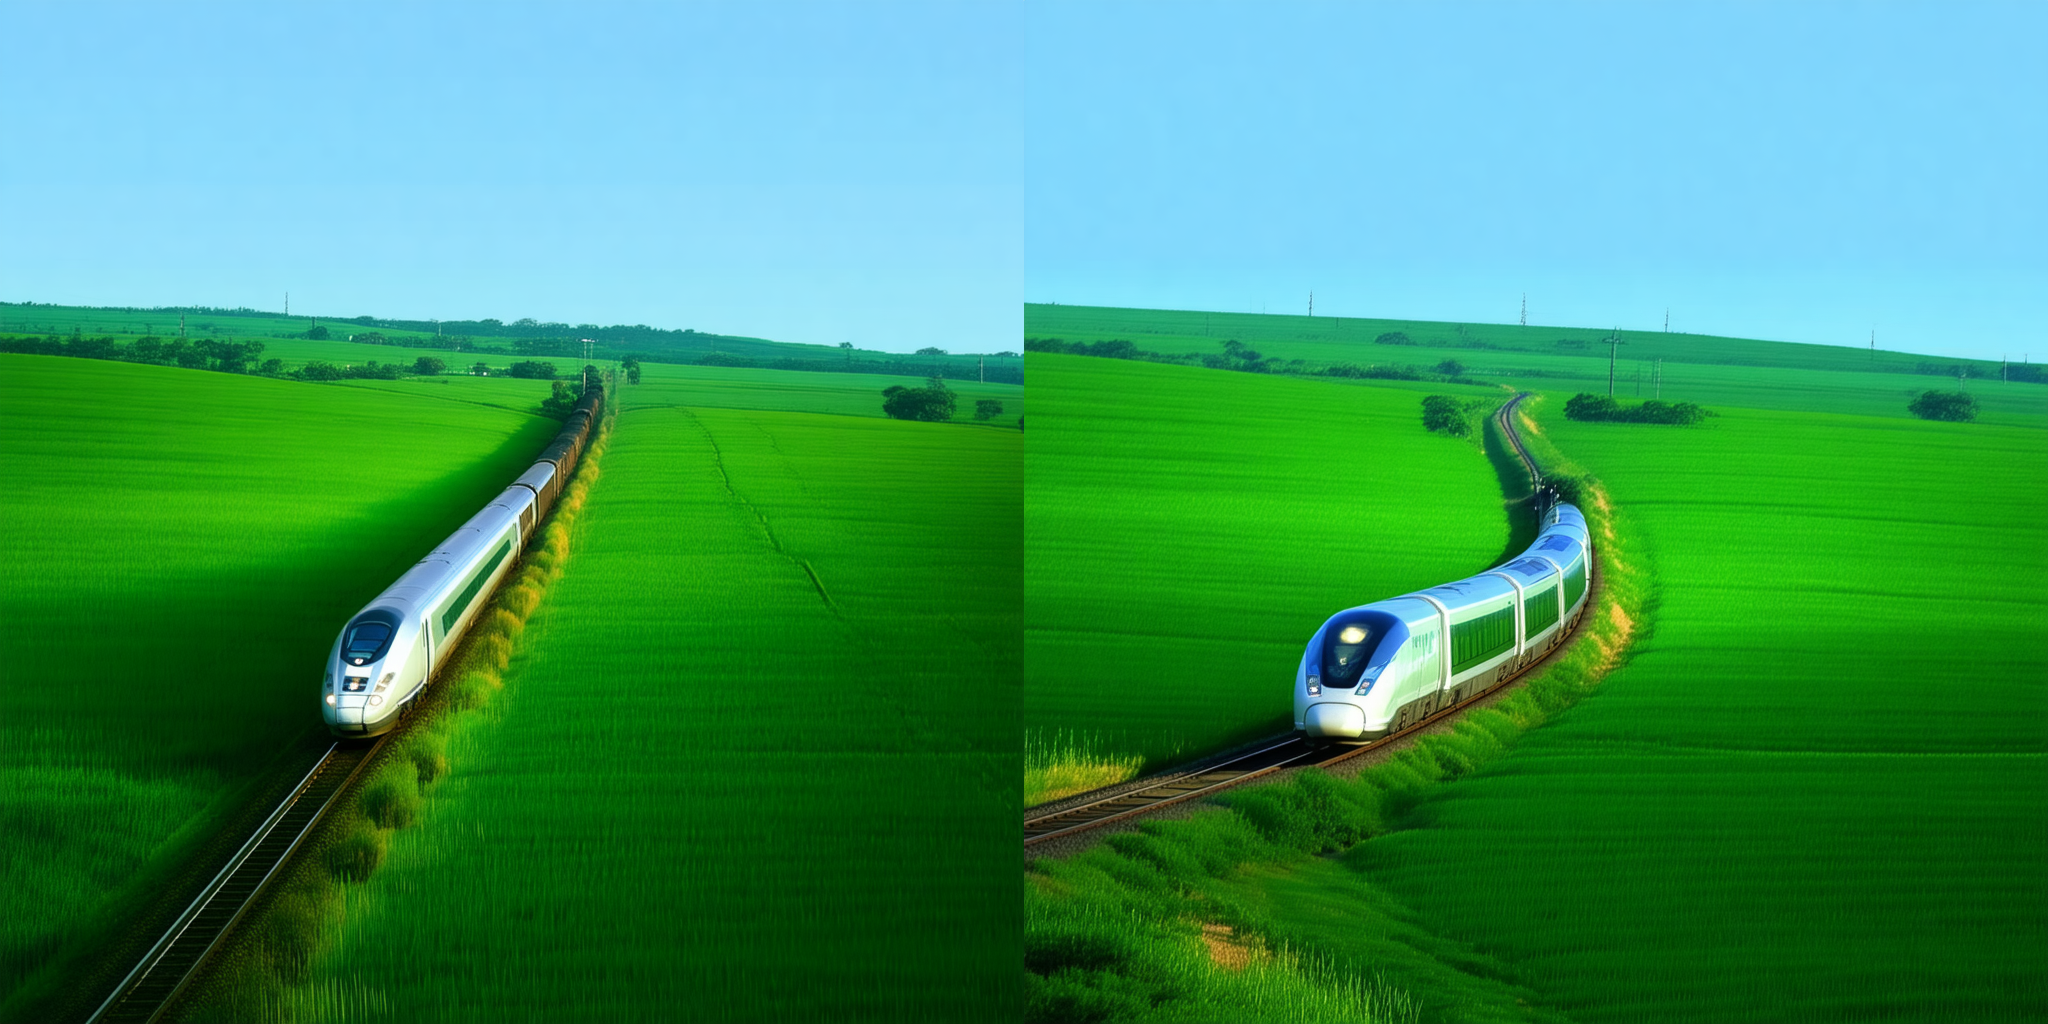

In [9]:
# with open("noun.txt", "r") as f:
#     lines = f.read().split("\n")
#     positive_prompt = [i.split(".")[0] + ", high quality, 8k, detailed" for i in lines if i.strip() != ""]
#     negative_prompt = [i.split(".")[1][1:] for i in lines if i.strip() != ""]

with open("prompts.json", "r") as f:
    prompts = json.load(f)

positive_prompt = [i["positive_prompt"] + ", high quality, 8k, detailed, realistic, super high resolution, trending on artstation" for i in prompts]
negative_prompt = [i["negative_prompt"] for i in prompts]
    
import time
import copy
idx = 4
seed = int(time.time())
print(f"Using seed: {seed}") 
print("Positive prompts:", positive_prompt[idx])
print("Negative prompts:", negative_prompt[idx])
    
for block in pipe.transformer.transformer_blocks:
    block.attn.processor.neg_prompt_len=max([
        len(pipe.tokenizer.tokenize(negative_prompt[idx])), 
        len(pipe.tokenizer_2.tokenize(negative_prompt[idx])),
        len(pipe.tokenizer_3.tokenize(negative_prompt[idx]))
    ]) + 1 

image_ours = pipe(
    positive_prompt[idx],
    negative_prompt=negative_prompt[idx],
    num_inference_steps = 16,
    avoidance_factor = 2e4,
    negative_offset = -5,# -11,
    clamp_value = 30,
    guidance_scale = 6,
    generator=torch.manual_seed(seed),
).images


weights = pipe.transformer.transformer_blocks[0].attn.processor.attn_weight
negative_guidance_scales = pipe.negative_guidance_scales
weight_maps = copy.deepcopy(pipe.weight_maps)
image_vanilla = pipe(
    positive_prompt[idx],
    negative_prompt=negative_prompt[idx],
    num_inference_steps=16,
    guidance_scale=6, 
    vanilla=True,
    generator=torch.manual_seed(seed),  
).images

# image_ban = pipe(
#     positive_prompt,
#     negative_prompt=negative_prompt,
#     num_inference_steps=30, 
#     guidance_scale=5, 
#     start_step=5,
#     end_step=15,
#     vanilla=True,
#     generator=torch.manual_seed(seed),  
# ).images


Image.fromarray(
            np.concatenate(
                [np.array(image_ours[-1]), np.array(image_vanilla[-1])], axis=1
                # [np.array(image_ours[-1]), np.array(image_vanilla[-1]), np.array(image_ban[-1])], axis=1
            ) 
 )

In [10]:
# check_moderation(image_ours[0]), check_moderation(image_vanilla[0])

In [11]:
image_ours[0].save("ours.png") 

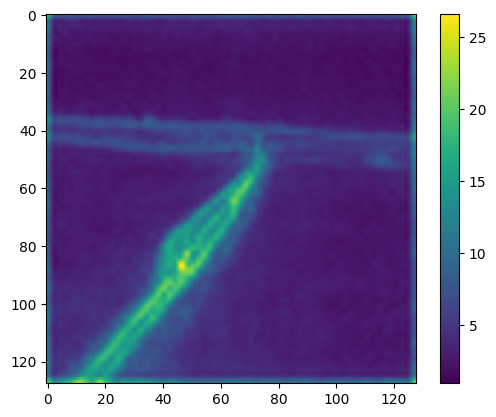

In [16]:
import pylab
pylab.imshow(weight_maps[-6].mean(0).mean(0).cpu().float().numpy())

pylab.colorbar() 
# weird edge effects, why? not working? did not detach why the house? because prompt is fence, so this is false positive? use simarlity not attention

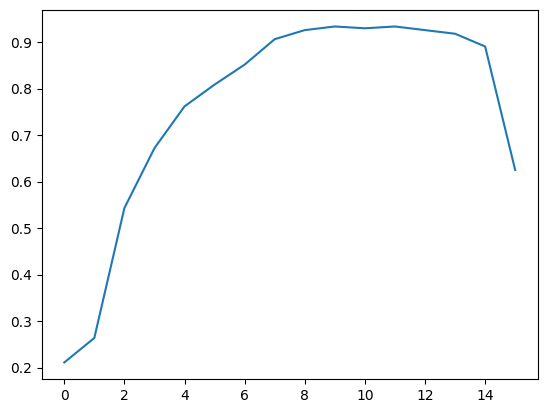

In [26]:
pylab.plot([i.mean().cpu().float().numpy() for i in weight_maps])

In [14]:
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForImageTextRetrieval

processor = BlipProcessor.from_pretrained("Salesforce/blip-itm-large-coco")
model = BlipForImageTextRetrieval.from_pretrained("Salesforce/blip-itm-large-coco").to("cuda")

raw_image = image_ours[-1]

question = "there are " + negative_prompt + " visible in the image"
# question = positive_prompt
inputs = processor(raw_image, question, return_tensors="pt").to("cuda")


with torch.no_grad():
    itm_scores = torch.nn.functional.softmax(model(**inputs)[0], dim=-1)
    cosine_score = model(**inputs, use_itm_head=False)[0]
itm_scores, cosine_score


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


TypeError: can only concatenate str (not "list") to str

In [ ]:
import requests
from PIL import Image
import torch
from PIL import ImageDraw

from transformers import Owlv2Processor, Owlv2ForObjectDetection

processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")

In [ ]:
text_labels = [[negative_prompt]]
raw_image = image_ours[-1].copy()
inputs = processor(text=text_labels, images=raw_image, return_tensors="pt")
outputs = model(**inputs)

# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.tensor([(raw_image.height, raw_image.width)])
# Convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
results = processor.post_process_grounded_object_detection(
    outputs=outputs, target_sizes=target_sizes, threshold=0.13, text_labels=text_labels
)

# Retrieve predictions for the first image for the corresponding text queries
result = results[0]
boxes, scores, text_labels = result["boxes"], result["scores"], result["text_labels"]
for box, score, text_label in zip(boxes, scores, text_labels):
    box = [round(i, 2) for i in box.tolist()]
    print(f"Detected {text_label} with confidence {round(score.item(), 3)} at location {box}")

# draw boxes 
draw = ImageDraw.Draw(raw_image)
for box, score, text_label in zip(boxes, scores, text_labels):
    box = [round(i, 2) for i in box.tolist()]
    draw.rectangle(box, outline="red", width=3)
    draw.text((box[0], box[1]), f"{text_label} {round(score.item(), 3)}", fill="red")
print(scores.max())
raw_image

RuntimeError: max(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.